In [1]:
import xarray as xa
from pathlib import Path

In [13]:
fps = list(Path("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coraltime/data/sst").glob("*.nc"))
ds = xa.open_mfdataset(fps)
ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 760, latitude: 641, longitude: 801)
Coordinates:
  * time       (time) datetime64[ns] 6kB 1985-04-01T12:00:00 ... 1987-04-30T1...
  * latitude   (latitude) float32 3kB 0.025 -0.025 -0.075 ... -31.92 -31.98
  * longitude  (longitude) float32 3kB 130.0 130.1 130.1 ... 169.9 170.0 170.0
Data variables:
    CRW_SST    (time, latitude, longitude) float64 3GB dask.array<chunksize=(30, 641, 801), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:            NOAA Coral Reef Watch (CRW)
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    Conventions:                CF-1.6, ACDD-1.3
    creator_email:              coralreefwatch@noaa.gov
    creator_institution:        NOAA Coral Reef Watch (CRW)
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          1985-04-30T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        1985-04-01T12:00:00Z
    title:                      NOAA Coral Reef Watch Operational Daily Near-...
    Westernmost_Easting:        130.025

In [19]:
# step-by-step guide to MMM calculation: https://coralreefwatch.noaa.gov/product/5km/tutorial/crw06a_climatology.php#:~:text=We%20then%20defined%20the%20Maximum,limit%20of%20%22usual%22%20temperature.
# calculate monthly mean SST for each calendar month
mm_sst = ds.resample(time='ME').mean()
mm_sst

<xarray.Dataset> Size: 103MB
Dimensions:    (latitude: 641, longitude: 801, time: 25)
Coordinates:
  * latitude   (latitude) float32 3kB 0.025 -0.025 -0.075 ... -31.92 -31.98
  * longitude  (longitude) float32 3kB 130.0 130.1 130.1 ... 169.9 170.0 170.0
  * time       (time) datetime64[ns] 200B 1985-04-30 1985-05-31 ... 1987-04-30
Data variables:
    CRW_SST    (time, latitude, longitude) float64 103MB dask.array<chunksize=(1, 641, 801), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:            NOAA Coral Reef Watch (CRW)
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    Conventions:                CF-1.6, ACDD-1.3
    creator_email:              coralreefwatch@noaa.gov
    creator_institution:        NOAA Coral Reef Watch (CRW)
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          1985-04-30T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        1985-04-01T12:00:00Z
    title:                      NOAA Coral Reef Watch Operational Daily Near-...
    Westernmost_Easting:        130.025

In [7]:
# average over space for each timestep
ds = xa.open_mfdataset(fps)
spatial_mean_ds = ds.mean(dim=["latitude", "longitude"])

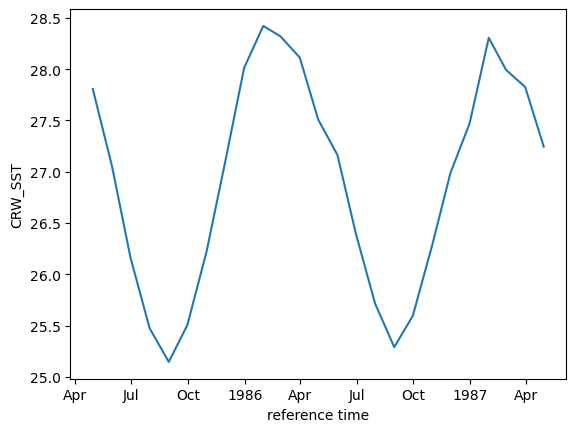

In [21]:
mm_sst["CRW_SST"].mean(dim=["latitude", "longitude"]).plot()

In [ ]:


url = "https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.nc?CRW_SST%5B(1985-04-01T12:00:00Z):1:(1985-05-01T12:00:00Z)%5D%5B(-32):1:(0)%5D%5B(130):1:(170)%5D"

In [ ]:
xa.open_mfdataset(list(Path("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coraltime/data/sst").glob("*.nc")))

In [ ]:
from pathlib import Path
import requests
import xarray as xa
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import tqdm.auto as tqdm

def download_nc_files(start_date, end_date, output_dir, var="CRW_SST"):
    url_base = f"https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.nc?{var}%5B"
    url_end = "%5D%5B(-32):1:(0)%5D%5B(130):1:(170)%5D"
    
    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%dT%H:%M:%SZ")
    end_date = datetime.strptime(end_date, "%Y-%m-%dT%H:%M:%SZ")
    
    # Iterate over month-by-month chunks
    while start_date < end_date:
        # Calculate the end of the month
        next_month = start_date + relativedelta(months=1)
        end_of_month = next_month.replace(day=1) - relativedelta(days=1)
        
        # Construct the URL for the current month
        month_url = f"{url_base}({start_date.isoformat()}):1:({end_of_month.isoformat()}){url_end}"
        
        # Download the data
        response = requests.get(month_url)
        if response.status_code == 200: # successful request
            # Parse the data with xarray
            data = xa.open_dataset(response.content)
            
            # Define the output file path
            output_filename = output_dir / f"{var}_{start_date.strftime('%Y-%m')}.nc"
            
            # Write the data to a NetCDF file
            data.to_netcdf(output_filename)
            print(f"Downloaded data for {start_date.strftime('%Y-%m-%d')} to {end_of_month.strftime('%Y-%m-%d')} "
                  f"and saved to {output_filename}")
        else:
            print(f"Failed to download data for {start_date.strftime('%Y-%m')} to {end_of_month.strftime('%Y-%m')}")
        
        # Move to the next month
        start_date = next_month

# Example usage:
url = "https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.nc?CRW_SST%5B(1985-04-01T12:00:00Z):1:(1985-05-01T12:00:00Z)%5D%5B(-32):1:(0)%5D%5B(130):1:(170)%5D"
start_date = "1985-04-01T12:00:00Z"
# end_date = "1985-07-01T12:00:00Z"
end_date = "2024-04-28T12:00:00Z"
output_dir = Path("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coraltime/data")

download_nc_files(start_date, end_date, output_dir)